In [1]:
# imports
from commstools.core import Preamble, SingleCarrierFrame
from commstools.logger import set_log_level

set_log_level("WARNING")


2026-02-13 16:47:14 [INFO] [commstools/backend.py] CuPy is available and functional, defaulting Signals to GPU.


In [2]:
symbol_rate = 100e9
sampling_rate = 200e9
sps = int(sampling_rate / symbol_rate)


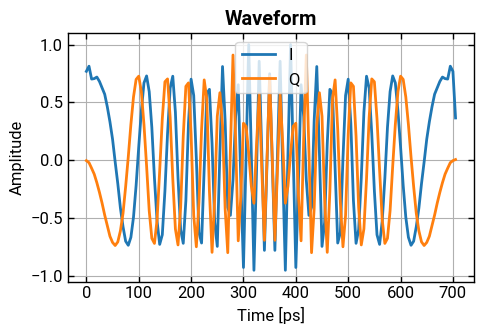

In [3]:
p = Preamble(sequence_type="zc", length=71)
ps = p.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
ps.plot_symbols(show=True)


In [4]:
f = SingleCarrierFrame(
    payload_len=10000,
    payload_seed=42,
    payload_mod_scheme="qam",
    payload_mod_order=64,
    preamble=p,
    preamble_mode="time_orthogonal",
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme="qam",
    pilot_mod_order=4,
    pilot_gain_db=0.0,
    num_streams=2,
)


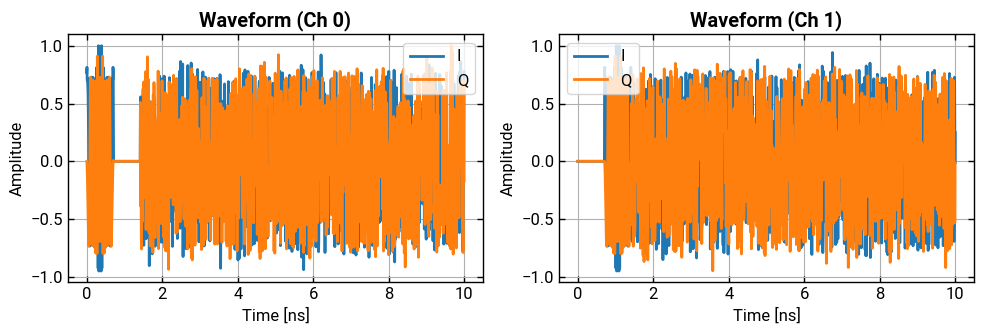

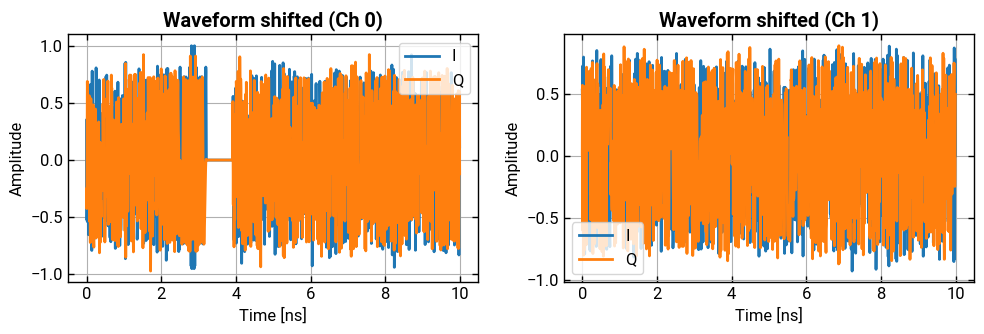

In [5]:
from commstools.backend import get_array_module

fs = f.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
fs.plot_symbols(show=True, num_symbols=1000)

xp = get_array_module(fs.samples)


fs.samples[0] = xp.roll(fs.samples[0], 500)
fs.samples[1] = xp.roll(fs.samples[1], 3333)
fs.plot_symbols(show=True, title="Waveform shifted", num_symbols=1000)


In [6]:
fs.matched_filter()


Signal(samples=array([[-0.45304216-0.34642525j, -0.04373654-0.62366946j,
         0.34960442-0.39581426j, ...,  0.43432228-0.30498846j,
        -0.1840504 -0.16807486j, -0.43870767-0.1091143j ],
       [ 0.49713078+0.29186069j,  0.72140785+0.55337922j,
         0.91741654+0.03400221j, ...,  0.68110233-0.67754022j,
         0.96115599-1.07663259j,  0.72437037-0.83940077j]],
      shape=(2, 22508)), sampling_rate=200000000000.0, symbol_rate=100000000000.0, modulation_scheme=None, modulation_order=None, source_bits=None, source_symbols=None, pulse_shape='rrc', spectral_domain='BASEBAND', physical_domain='DIG', center_frequency=0, digital_frequency_offset=0, filter_span=10, rrc_rolloff=0.35, rc_rolloff=0.35, gaussian_bt=0.3, smoothrect_bt=1.0, signal_info=SignalInfo(signal_type='single_carrier_frame', preamble_seq_len=71, preamble_type='zc', preamble_mode='time_orthogonal', preamble_kwargs={}, payload_len=10000, payload_mod_scheme='qam', payload_mod_order=64, pilot_count=1112, pilot_patter

2026-02-13 16:47:15 [WARNING] [commstools/sync.py] Skew detected among valid channels! Valid Peaks: [500, 3333]. Spread: 2833 samples.


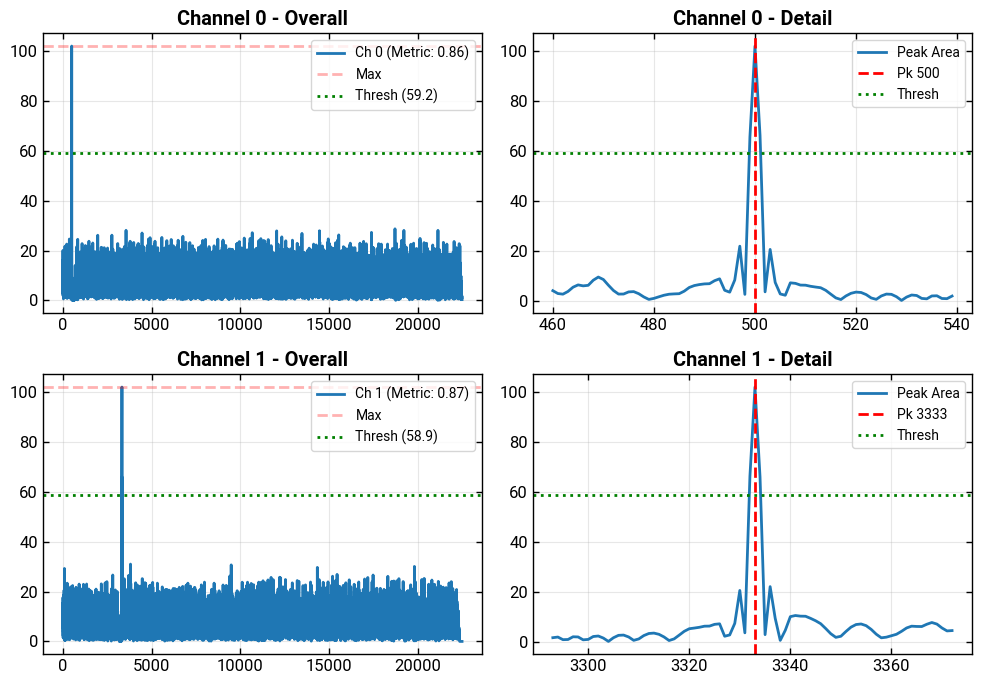

[ 500 3333]


In [7]:
from commstools.sync import detect_frame

print(detect_frame(fs, p, return_metric=False, debug_plot=True))


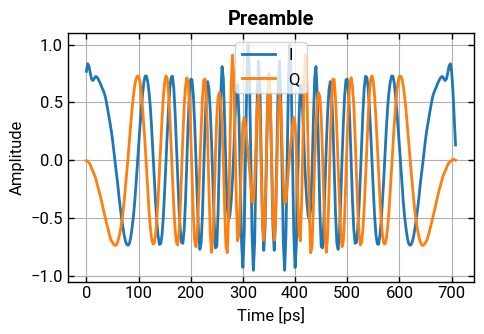

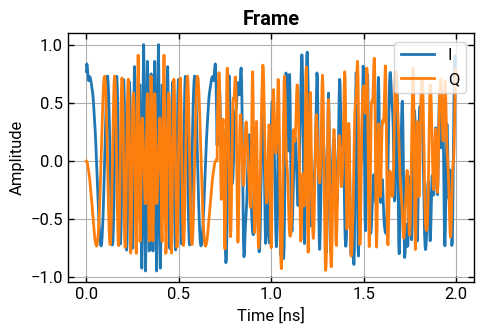

In [65]:
# imports
from commstools.core import Preamble, SingleCarrierFrame
from commstools.logger import set_log_level

set_log_level("WARNING")


symbol_rate = 100e9
sampling_rate = 400e9
sps = int(sampling_rate / symbol_rate)

p = Preamble(sequence_type="zc", length=71)

f = SingleCarrierFrame(
    payload_len=80000,
    payload_seed=42,
    payload_mod_scheme="qam",
    payload_mod_order=16,
    preamble=p,
    pilot_pattern="comb",
    pilot_period=10,
    pilot_block_len=1,
    pilot_seed=1337,
    pilot_mod_scheme="qam",
    pilot_mod_order=4,
    pilot_gain_db=0.0,
)

ps = p.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
ps.plot_symbols(show=True, title="Preamble")

fs = f.to_signal(sps=sps, symbol_rate=symbol_rate, pulse_shape="rrc")
# fs.plot_symbols(show=True, start_symbol=69, num_symbols=10, title="Frame")
fs.plot_symbols(show=True, num_symbols=200, title="Frame")


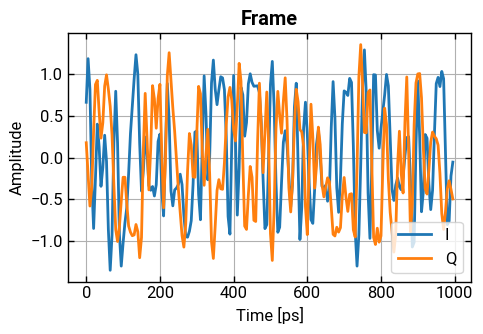

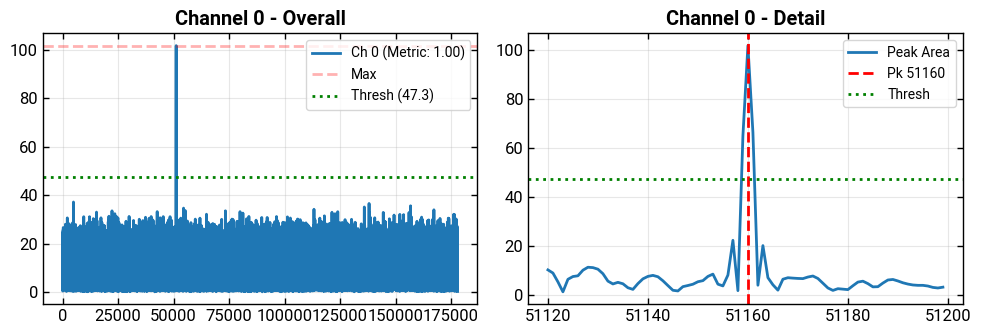

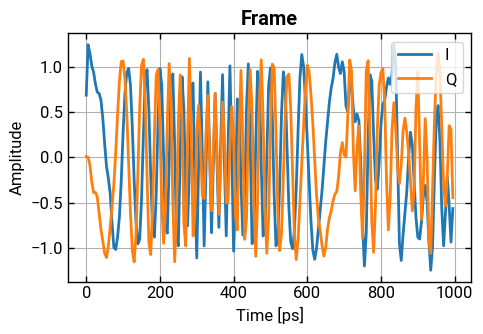

In [85]:
from commstools.backend import get_array_module
from commstools.sync import detect_frame
from commstools.impairments import add_awgn

rxfs = fs.copy()
xp = get_array_module(rxfs.samples)

rxfs.samples = add_awgn(rxfs.samples, esn0_db=20, sps=rxfs.sps)
rxfs.samples = xp.roll(rxfs.samples, 102320)
# rxfs.samples = add_awgn(rxfs.samples, esn0_db=20, sps=sps)

rxfs.resample(sps_out=2)
rxfs.matched_filter()
rxfs.plot_symbols(show=True, num_symbols=100, title="Frame")

fix = detect_frame(rxfs, p, return_metric=True, debug_plot=True)

rxfs.samples = xp.roll(rxfs.samples, -fix[0])
rxfs.plot_symbols(show=True, num_symbols=100, title="Frame")


In [86]:
rxfs.samples = rxfs.samples[p.num_symbols * rxfs.sps :]


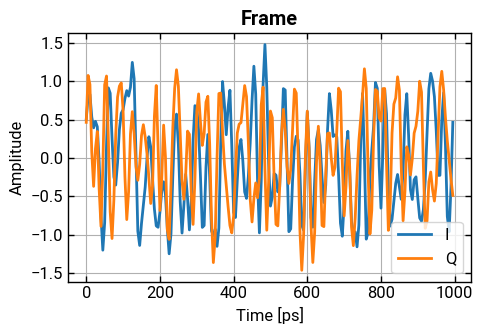

In [87]:
rxfs.plot_symbols(show=True, num_symbols=100, title="Frame")


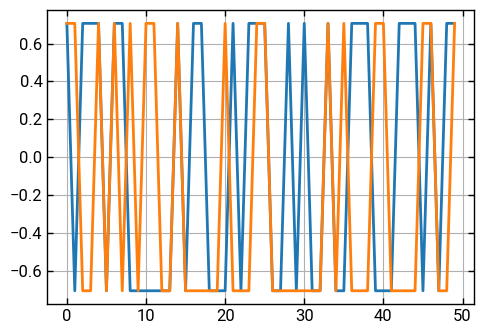

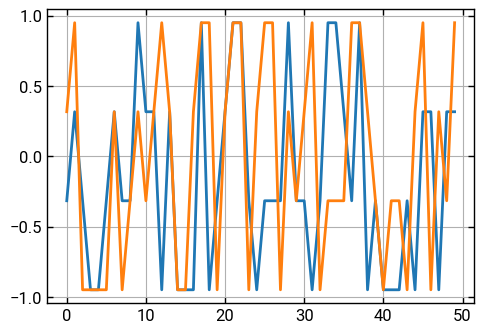

In [88]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(f.pilot_symbols[50:100].get().real)
plt.plot(f.pilot_symbols[50:100].get().imag)
plt.show()


plt.figure()
plt.plot(f.payload_symbols[50:100].get().real)
plt.plot(f.payload_symbols[50:100].get().imag)
plt.show()


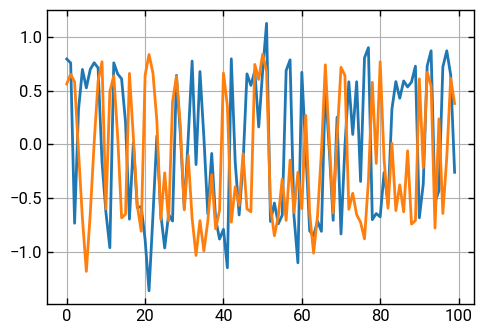

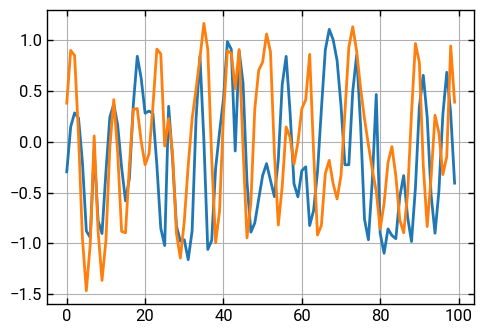

In [89]:
map = f.get_structure_map(unit="samples", sps=rxfs.sps)


plt.figure()
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()

plt.figure()
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()


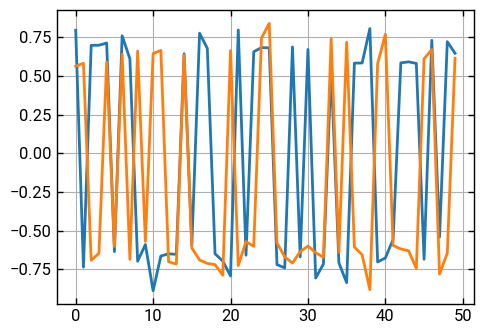

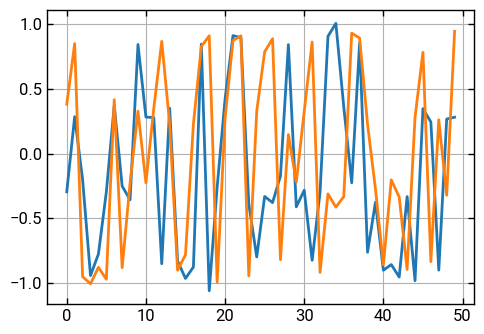

In [90]:
rxfs.downsample_to_symbols(offset=0)
map = f.get_structure_map(unit="samples", sps=rxfs.sps)

plt.figure()
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["pilots"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()

plt.figure()
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().real)
plt.plot(rxfs.samples[map["payload"]][50 * rxfs.sps : 100 * rxfs.sps].get().imag)
plt.show()


In [91]:
pilots = rxfs.copy()
pilots.source_symbols = f.pilot_symbols
pilots.source_bits = f.pilot_bits
pilots.samples = pilots.samples[map["pilots"]]

payload = rxfs.copy()
payload.source_symbols = f.payload_symbols
payload.source_bits = f.payload_bits
payload.samples = payload.samples[map["payload"]]


In [92]:
payload.resolve_symbols()
payload.evm()


(9.978800019469066, -20.018433615648043)

In [93]:
pilots.resolve_symbols()
pilots.evm()


(9.994799140299847, -20.004518584465934)

In [94]:
f.payload_symbols


array([ 0.9486833 +0.9486833j ,  0.31622776-0.31622776j,
        0.31622776+0.31622776j, ...,  0.31622776-0.9486833j ,
        0.31622776-0.9486833j , -0.9486833 -0.31622776j],
      shape=(80000,), dtype=complex64)

In [95]:
payload.resolved_symbols


array([ 0.87496722+1.01110139j,  0.41499417-0.38854497j,
        0.43004806+0.3651777j , ...,  0.2027297 -0.93220956j,
        0.40967747-0.98603373j, -1.01653954-0.22150087j], shape=(80000,))

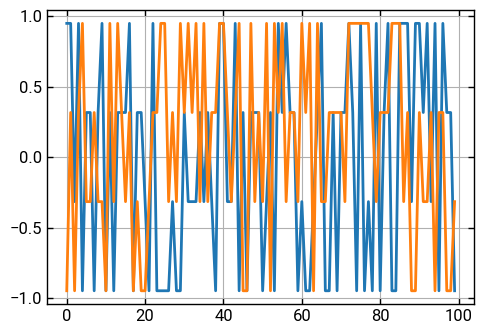

In [96]:
plt.plot(payload.source_symbols.real[-100:].get())
plt.plot(payload.source_symbols.imag[-100:].get())


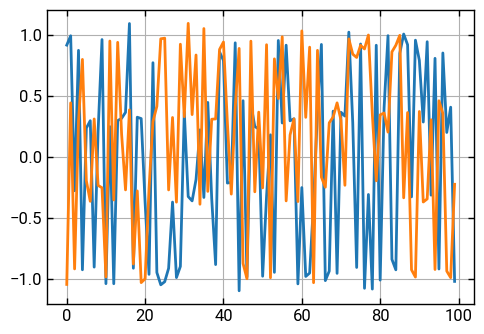

In [97]:
plt.plot(payload.resolved_symbols.real[-100:].get())
plt.plot(payload.resolved_symbols.imag[-100:].get())


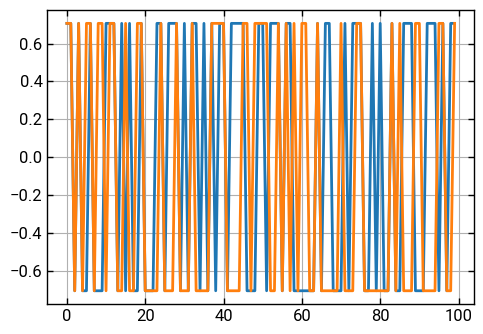

In [98]:
plt.plot(pilots.source_symbols.real[:100].get())
plt.plot(pilots.source_symbols.imag[:100].get())


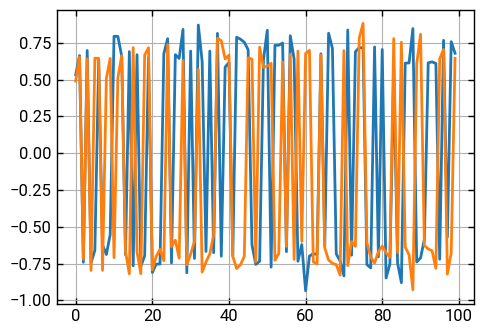

In [99]:
plt.plot(pilots.resolved_symbols.real[:100].get())
plt.plot(pilots.resolved_symbols.imag[:100].get())


2026-02-13 17:04:20 [WARNING] [commstools/plotting.py] Modulation and order must be provided to overlay ideal constellation.


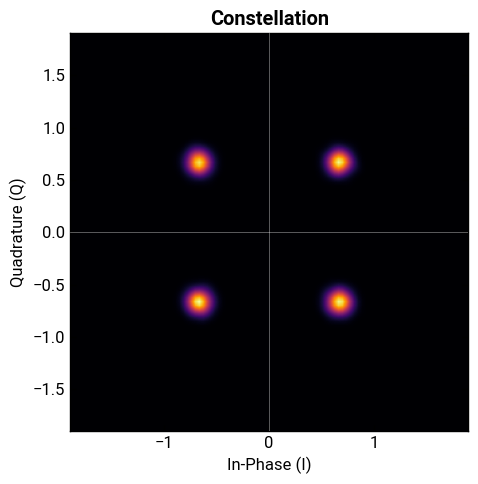

In [100]:
pilots.plot_constellation(overlay_ideal=True, show=True)


2026-02-13 17:04:20 [WARNING] [commstools/plotting.py] Modulation and order must be provided to overlay ideal constellation.


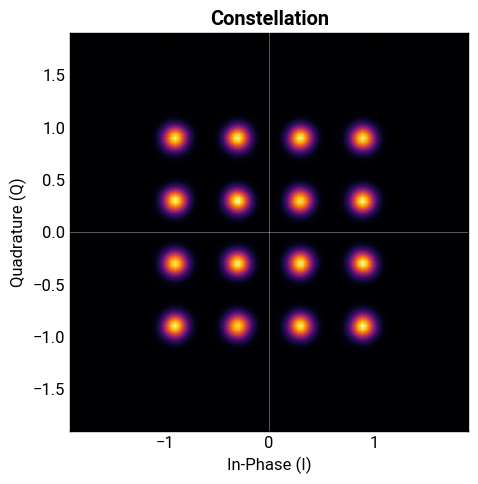

In [101]:
payload.plot_constellation(overlay_ideal=True, show=True)


In [102]:
pilots.modulation_scheme = "qam"
pilots.modulation_order = 4
pilots.demap()
pilots.ber()


0.0

In [103]:
payload.modulation_scheme = "qam"
payload.modulation_order = 16
payload.demap()
payload.ber()


6.25e-06